<span style='color:#009999'> <span style='font-family:serif'> <font size="15"> **PACE: Ocean Color Data**<span style='color:#0066cc'> 

<img src="img/PACE.png" alt="drawing" width="750"/>    

<span style='color:#ff6666'><font size="5">Requirements
1. <font size="3"><span style='color:Black'> Have a Bearer Token for EarthData in the Cloud (See Getting Started Notebook).
2. <font size="3"><span style='color:Black'> Upload the Bearer Token from local file`token.json`



 <span style='color:#ff6666'><font size="5">Objectives
- <font size="3"><span style='color:Black'> To access `PACE` data via OPeNDAP URL.
- <font size="3"><span style='color:Black'> To interactively inspect remote data, and figure out subsetting region (if any)
- <font size="3"><span style='color:Black'>  Understand differences in DAP2 and DAP4 (data representation, access)
- <font size="3"><span style='color:Black'> To demonstrate a workflow that exploits xarray parallelism. and DAP4 representation



<span style='color:#ff6666'><font size="5"> Browsing Data:

<font size="3"><span style='color:Black'> Broad information about the dataset can be found on the PACE website (see [here](https://oceandata.sci.gsfc.nasa.gov))


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from pydap.client import open_url
import json
import cartopy.crs as ccrs

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **PACE Access via OPeNDAP**

<font size="3"><span style='color:Black'> The PACE OPeNDAP data catalog can be found [here](https://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/contents.html). Data only starts in 2024


- <font size="3"><span style='color:Black'> Make distinction between DAP2 and DAP4.



In [41]:

# slow download URL
url_DAP4 = "dap4://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0717/PACE_OCI.20240710.L3m.DAY.CHL.V2_0.chlor_a.4km.NRT.nc"

# This Dataset has no missing data and downloads much faster.
url = "http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0301/PACE_OCI.20240301_20240331.L3m.MO.CHL.V2_0.chlor_a.0p1deg.NRT.nc"


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Import Token Authorization and create Session**
 

In [4]:
# load token json data
with open('token.json', 'r') as fp:
    Authorization = json.load(fp)

# pass Token Authorization to a new Session.
my_session = requests.Session()
my_session.headers = Authorization


In [5]:
%%time
ds = open_url(url_DAP2, session=my_session)

/Users/miguelangeljimenezurias/mambaforge/envs/ESIP2024/lib/python3.10/site-packages/pydap/handlers/dap.py:120: UserWarning: PyDAP was unable to determine the DAP protocol defaulting to DAP2 which is consider legacy and may result in slower responses. For more, see go to https://www.opendap.org/faq-page.
  _warnings.warn(


CPU times: user 76.6 ms, sys: 13.9 ms, total: 90.5 ms
Wall time: 1.75 s


In [42]:
%%time
ds = open_url(url, session=my_session, protocol='dap4')

CPU times: user 38.1 ms, sys: 11.1 ms, total: 49.3 ms
Wall time: 919 ms


In [43]:
ds.tree()

.PACE_OCI.20240301_20240331.L3m.MO.CHL.V2_0.chlor_a.0p1deg.NRT.nc
├──lat
├──lon
├──chlor_a
├──palette
├──rgb
└──eightbitcolor


In [44]:
ds['chlor_a'].attributes

{'long_name': 'Chlorophyll Concentration, OCI Algorithm',
 'units': 'mg m^-3',
 'standard_name': 'mass_concentration_of_chlorophyll_in_sea_water',
 '_FillValue': -32767.0,
 'valid_min': 0.00100000005,
 'valid_max': 100.0,
 'reference': 'Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on three-band reflectance difference, J. Geophys. Res., 117, C01011, doi:10.1029/2011JC007395.',
 'display_scale': 'log',
 'display_min': 0.00999999978,
 'display_max': 20.0}

In [45]:
print('uncompressed dataset size [GBs]: ', ds.nbytes / 1e9)

uncompressed dataset size [GBs]:  0.02594444


In [46]:
ds['chlor_a'].shape

(1800, 3600)

In [47]:
print('uncompressed dataset size [GBs]: ', ds['chlor_a'].nbytes / 1e9)

uncompressed dataset size [GBs]:  0.02592


In [48]:
%%time
chlor_a = ds['chlor_a'][:]

CPU times: user 2.19 s, sys: 2.43 s, total: 4.62 s
Wall time: 6.79 s


In [49]:
chlor_a.attributes

{'long_name': 'Chlorophyll Concentration, OCI Algorithm',
 'units': 'mg m^-3',
 'standard_name': 'mass_concentration_of_chlorophyll_in_sea_water',
 '_FillValue': -32767.0,
 'valid_min': 0.00100000005,
 'valid_max': 100.0,
 'reference': 'Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on three-band reflectance difference, J. Geophys. Res., 117, C01011, doi:10.1029/2011JC007395.',
 'display_scale': 'log',
 'display_min': 0.00999999978,
 'display_max': 20.0,
 'checksum': array([2201688348], dtype=uint32),
 'Maps': ('/lat', '/lon')}

In [50]:
chlor_a.nbytes/1e9

0.02592



<span style='color:#ff6666'><font size="5">**CF - Conventions**

<font size="3"><span style='color:Black'> In OPeNDAP's metadata rich datasets, each contains standard attributes used to describe missing data, units in which the data is presented, and any stretching/scaling of the values. 

- <font size="3"><span style='color:Black'> `standard name`
- <font size="3"><span style='color:Black'> `units`
- <font size="3"><span style='color:Black'> `_FillValue`
- <font size="3"><span style='color:Black'> `scale_factor`
- <font size="3"><span style='color:Black'> `off_set`

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Decode Values**




In [51]:
def decode(variable) -> np.ndarray:
    """Decodes the variable BaseType according with atributes:
        _FillValue
        scale_factor

    Parameters:
        variable: BaseType (pydap model)
    """
    scale_factor = 1
    _Fillvalue = None

    if 'scale_factor' in variable.attributes:
        scale_factor = variable.scale_factor
    if '_FillValue' in variable.attributes:
        data = np.where(variable.data == variable._FillValue, np.nan, variable.data)    
    else:
        data = variable.data
    return scale_factor * data

In [52]:
%%time
CHLOR_A = decode(chlor_a)

CPU times: user 20.4 ms, sys: 17.7 ms, total: 38 ms
Wall time: 38.5 ms


In [53]:
CHLOR_A.shape

(1800, 3600)

In [54]:
Lon, Lat = np.meshgrid(decode(ds['lon'][:]), decode(ds['lat'][:]))

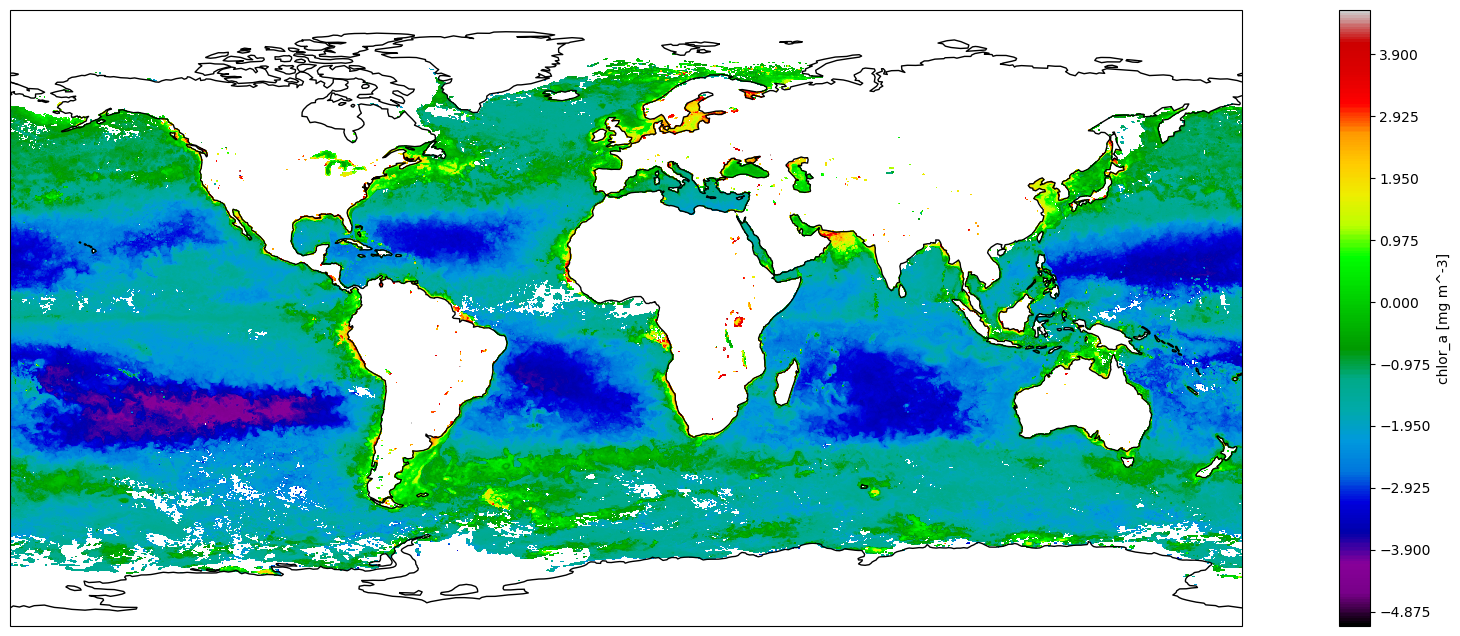

CPU times: user 16.3 s, sys: 348 ms, total: 16.6 s
Wall time: 16.8 s


In [55]:
%%time
plt.figure(figsize=(25, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
plt.contourf(Lon, Lat, np.log(CHLOR_A), 400, cmap='nipy_spectral')
plt.colorbar().set_label(chlor_a.name + ' ['+chlor_a.units+']')
plt.show()

<font size="5"><span style='color:#0066cc'> **Exercise**

<font size="3.5"><span style='color:black'> Using the global map above:
- <font size="3.5"> Visually narrow the global domain to a region of interest by subsetting the arrays in index space. 
- <font size="3.5"> Once you have identified the subdomain of interest, identify the index of the array.
- <font size="3.5"> Using the indexes of your (sub)domain of interest, create a constraint expression following the syntax:

```python
<base_url>?dap.ce=/chlor_a[<index>, <index>];/lat[<index>];/lon[<index>]
```
- <font size="3.5"> Use the constraint expression to subset your dataset, via pydap + OPeNDAP's Hyrax.
- <font size="3.5"> Use the `plot` snippet above but with `ax.set_global()` commented.